In [4]:
import quandl
import pandas as pd
import quandl as q
import numpy as np
import matplotlib.pyplot as plt
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [5]:
#pega os dados da API
msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


In [6]:
#retorno diário
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Adj_Close']]

# retorna a fracao
daily_return = daily_close.pct_change()

# replaca de NA por 0
daily_return.fillna(0, inplace=True)

#print(daily_return)

In [7]:
#media movel 7 dias
adj_price = msft_data['Adj_Close']
mav = adj_price.rolling(window=15).mean()

Date
2017-12-14    80.982311
2017-12-15    81.213647
2017-12-18    81.375389
2017-12-19    81.436606
2017-12-20    81.577083
2017-12-21    81.662786
2017-12-22    81.743335
2017-12-26    82.021711
2017-12-27    82.287199
2017-12-28    82.476650
Name: Adj_Close, dtype: float64


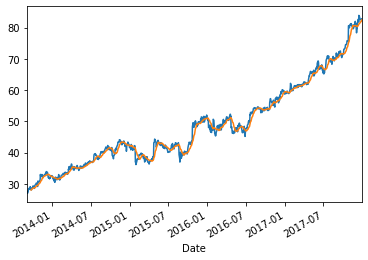

In [8]:
# print mav
print(mav[-10:])
adj_price.plot()
mav.plot()

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

#teste de estacionariedade
result = adfuller(daily_close.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ValueError: too many values to unpack (expected 2)

In [ ]:
## p >0.05, não é estacionária

In [10]:
df = pd.DataFrame(daily_close)

In [11]:
#import numpy as np, pandas as pd
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

#df = pd.DataFrame(daily_close)

# Original Series
#fig, axes = plt.subplots(3, 2, sharex=True)
#axes[0, 0].plot(df.values); axes[0, 0].set_title('Original Series')
#plot_acf(df.values, ax=axes[0, 1])

# 1st Differencing
#axes[1, 0].plot(df.diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
#plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
#axes[2, 0].plot(df.diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
#plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

#plt.show()

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(df.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [13]:
model_fit.plot_predict(dynamic=False)
plt.show()

NameError: name 'model_fit' is not defined

In [14]:
#vendo previsão
from statsmodels.tsa.stattools import acf

# Cria treino e teste
train = df.Adj_Close[:300]
test = df.Adj_Close[300:]

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Precisao
fc, se, conf = fitted.forecast(790, alpha=0.05)  # 95% conf

# Serie_panda
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

c:\users\binks\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\binks\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [15]:
#melhor modelo arima

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

ModuleNotFoundError: No module named 'pmdarima'

In [16]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

AttributeError: 'ARIMA' object has no attribute 'plot_diagnostics'

In [17]:
#previsão do modelo futura

# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

TypeError: predict() got an unexpected keyword argument 'n_periods'